<a href="https://colab.research.google.com/github/SNMS95/ADTO/blob/main/examples/neuralTO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Neural Topology Optimization for Compliance Minimization

### 🛠️ Computational Pipeline

We follow this simple pipeline:

> Neural Network → Enforce Volume Constraint → Density Filter → Linear Solve → Compliance

In [11]:
# === User-defined Settings for Neural Topology Optimization ===

ML_framework_to_use = "torch"  # Choose ML backend: "torch" or "jax"

# Grid resolution (number of finite elements in x and y directions)
# ⚠️ CNN only supports multiples of 8 for Nx and Ny
Nx = 96                       # Number of elements along x-axis
Ny = 64                       # Number of elements along y-axis

# Material properties
E0 = 1.0                     # Young's modulus of solid material
Emin = 1e-9                  # Young's modulus of void
nu = 0.3                     # Poisson's ratio

# Filter and penalization
rmin = 2.0                   # Radius for density filter
penal = 3.0                  # SIMP penalization factor

# Optimization control
max_iterations = 120         # Number of optimization steps
random_seed = 0            # Seed for network initialization
volfrac = 0.4
# ℹ️ Changing seed can change the starting point of optimization

# Optimizer settings
# ℹ️ Optimizers from https://keras.io/api/optimizers/
optimizer_str = "adam"          # Optimizer choice: "adam", "sgd", "rmsprop", or "adagrad"
optimizer_hyper_params = {
    "learning_rate": 1e-4,   # Learning rate for the optimizer,
    "global_clipnorm": 1.0,
}

# Neural network architecture settings
nn_type = "siren"  # Choose "mlp", "siren", or "cnn"
nn_arch_details = {
    # For MLP
    'num_hidden_layers': 3,
    'hidden_units': 256,

    # For SIREN
    'frequency_factor': 30.0,

    # For CNN
    "latent_size": 128
                  }

# Sanity checks
assert ML_framework_to_use in ["jax", "torch"]
assert isinstance(random_seed, int)
assert penal >= 1
assert rmin >= 1
assert isinstance(optimizer_str, str)
assert optimizer_str in ["adam", "sgd", "rmsprop", "adagrad"]
if nn_type.lower() == "cnn":
  assert Nx % 8 == 0 and Ny % 8 == 0, "CNN needs multiples of 8 for Nx & Ny"

In [12]:
# Check if in Colab and setup accordingly
try:
    import google.colab
    import os
    import sys
    
    if not os.path.exists('ADTO'):
        !git clone https://github.com/SNMS95/ADTO.git
    
    %cd ADTO
    !pip install -e .
    
    # Add src directory to path
    repo_path = '/content/ADTO/src'
    if repo_path not in sys.path:
        sys.path.insert(0, repo_path)
    
    print("🔧 Colab setup complete")
except:
    print("🔧 Running locally")

# Set backend before importing anything else
import os
os.environ["ML_BACKEND"] = ML_framework_to_use

# Now safe to import
from adto import (
    setup_fea_problem,
    solve,
    reduce_K,
    assemble_stiffness_matrix_parts,
    apply_density_filter,
    volume_enforcing_filter
)
from adto.nn_models import get_optimizer, create_network_and_input

if ML_framework_to_use == "jax":
    import jax
    import jax.numpy as jnp
else:
    import torch

🔧 Running locally


In [13]:
def simp_and_reduced_solve(physical_densities, problem_data):
    # Compute compliance
    E = problem_data['E_min'] + physical_densities**penal * \
        (problem_data['E0'] - problem_data['E_min'])
    iK, jK, sK = assemble_stiffness_matrix_parts(E, problem_data)
    free_dofs = problem_data['free']
    f = problem_data['F']
    f_f = f[free_dofs]
    # reduce K to K_f
    iK_f, jK_f, sK_f = reduce_K(iK, jK, sK, free_dofs, len(f))
    # Solve system
    if ML_framework_to_use == "torch":
        # Torch needs tensor inputs to be passed since we provide gradients w.r.t the force vector as well in teh custom VJP rule
        u_f = solve(sK_f, iK_f, jK_f, torch.tensor(f_f, device=sK_f.device, dtype=sK_f.dtype))
    else:
        u_f = solve(sK_f, iK_f, jK_f, f_f)
    return u_f

def run_with_jax_backend(problem_data, nn_model, nn_input, max_iterations=100,
                         trainable_vars=None, non_trainable_vars=None):
    """Training example with JAX backend"""
    print("Training with JAX backend...")

    # Create loss function and optimizer
    def loss_fn(train_vars, non_train_vars):
        # NN call
        output, non_train_vars = nn_model.stateless_call(
                train_vars, non_train_vars, nn_input)
        output = output.astype(jnp.float64)
        rho = volume_enforcing_filter(output, volfrac)
        rho = rho.ravel(order='F')
        physical_densities = apply_density_filter(rho, problem_data)
        # Compute compliance - SIMP, assemble K, Remove free DOFs, solve system
        u_f = simp_and_reduced_solve(physical_densities, problem_data)
        f_f = problem_data['F'][problem_data['free']]
        compliance = u_f.T @ f_f
        return compliance, (non_train_vars, physical_densities)

    optimizer = get_optimizer(optimizer_str, **optimizer_hyper_params)

    # Training state
    trainable_vars = [v.value for v in nn_model.trainable_variables]
    non_trainable_vars = nn_model.non_trainable_variables
    optimizer.build(nn_model.trainable_variables)
    opt_vars = optimizer.variables

    # Training loop
    losses = []
    designs = []
    for epoch in range(max_iterations):
        (loss, (non_trainable_vars, design)), grads = jax.value_and_grad(
            loss_fn, has_aux=True)(trainable_vars, non_trainable_vars)
        trainable_vars, opt_vars = optimizer.stateless_apply(
            opt_vars, grads, trainable_vars)
        losses.append(loss)
        designs.append(design)
        if epoch % 5 == 0:
            print(f"JAX - Epoch {epoch}, Loss: {loss:.6f}")

    return losses, designs, (trainable_vars, non_trainable_vars)


def run_with_torch_backend(problem_data, nn_model, nn_input, max_iterations=100):
    """Training example with PyTorch backend"""
    print("Training with PyTorch backend...")

    # Setup optimizer
    optimizer = get_optimizer(optimizer_str, **optimizer_hyper_params)

    # Training loop
    losses = []
    designs = []
    for epoch in range(max_iterations):
        with torch.enable_grad():
            # Forward pass
            output = nn_model(nn_input)
            rho = volume_enforcing_filter(output, volfrac)
            rho = rho.t().reshape(-1)  # equivalent to Fortran order flatten
            physical_densities = apply_density_filter(rho, problem_data)
            u_f = simp_and_reduced_solve(physical_densities, problem_data)
            compliance = u_f @ torch.tensor(problem_data['F'][problem_data['free']], device=u_f.device, dtype=u_f.dtype)

            # Backward pass
            nn_model.zero_grad()
            trainable_weights = [v for v in nn_model.trainable_weights]

            # Call torch.Tensor.backward() on the loss to compute gradients
            # for the weights.
            compliance.backward()
            gradients = [v.value.grad for v in trainable_weights]

            # Update weights
            with torch.no_grad():
                optimizer.apply(gradients, trainable_weights)

        losses.append(compliance.item())
        designs.append(physical_densities.detach().cpu().numpy())

        if epoch % 5 == 0:
            print(f"PyTorch - Epoch {epoch}, Loss: {compliance.item():.6f}")

    # Just for API consistency, return None for non-trainable vars
    return losses, designs, (nn_model, None)

def run_neural_optimization(problem_data, nn_model, nn_input, max_iterations=100,
                            trainable_vars=None, non_trainable_vars=None):
    """Train the neural network model."""
    backend = ML_framework_to_use
    if backend == "jax":
        return run_with_jax_backend(problem_data, nn_model, nn_input, max_iterations=max_iterations,
                                    trainable_vars=trainable_vars, non_trainable_vars=non_trainable_vars)
    elif backend == "torch":
        return run_with_torch_backend(problem_data, nn_model, nn_input, max_iterations=max_iterations)
    else:
        raise ValueError(f"Unknown backend: {backend}")

In [23]:
problem_data = setup_fea_problem(Nx=Nx, Ny=Ny, rmin=rmin, E0=E0, Emin=Emin, penal=penal,
                        nu=nu)
nn, nn_input = create_network_and_input(nn_type=nn_type, hyper_params=nn_arch_details,
                                   random_seed=random_seed, grid_size=(Ny, Nx))
# For torch, the NN model contains both trainable and non-trainable vars
# i.e., run_neural_optimization returns (nn_model, None)
objs, designs, (trainable_vars, non_trainable_vars) = run_neural_optimization(problem_data, nn, nn_input, max_iterations=max_iterations)

Training with PyTorch backend...
PyTorch - Epoch 0, Loss: 498.911041
PyTorch - Epoch 5, Loss: 430.739197
PyTorch - Epoch 10, Loss: 389.476501
PyTorch - Epoch 15, Loss: 345.736176
PyTorch - Epoch 20, Loss: 302.102020
PyTorch - Epoch 25, Loss: 264.259705
PyTorch - Epoch 30, Loss: 237.090149
PyTorch - Epoch 35, Loss: 216.272934
PyTorch - Epoch 40, Loss: 195.079025
PyTorch - Epoch 45, Loss: 172.319122
PyTorch - Epoch 50, Loss: 150.266205
PyTorch - Epoch 55, Loss: 133.045364
PyTorch - Epoch 60, Loss: 118.759628
PyTorch - Epoch 65, Loss: 106.336914
PyTorch - Epoch 70, Loss: 96.186600
PyTorch - Epoch 75, Loss: 88.478165
PyTorch - Epoch 80, Loss: 82.653198
PyTorch - Epoch 85, Loss: 78.213326
PyTorch - Epoch 90, Loss: 74.852173
PyTorch - Epoch 95, Loss: 72.166405
PyTorch - Epoch 100, Loss: 70.044899
PyTorch - Epoch 105, Loss: 68.439461
PyTorch - Epoch 110, Loss: 67.132675
PyTorch - Epoch 115, Loss: 66.100296


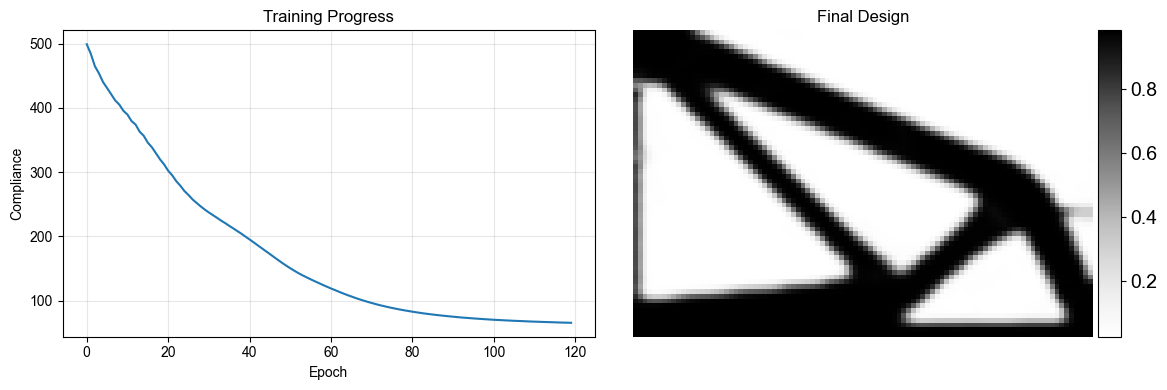

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
ax1.plot(objs,)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Compliance')
ax1.set_title('Training Progress')
ax1.grid(True, alpha=0.3)

# Final design
im = ax2.imshow(designs[-1].reshape(Ny, Nx, order='F'), cmap="Greys")
ax2.set_title('Final Design')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.axis("off")
# Attach colorbar axis with same height
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)  # narrow, right-side
cbar = fig.colorbar(im, cax=cax)

# Formatting
cbar.ax.tick_params(labelsize=14)
plt.rcParams.update({"font.sans-serif": "Arial", "font.family": "sans-serif"})

# Save as PDF
# fig.savefig(f"{nn_type}_design.pdf", bbox_inches="tight", dpi=600)
plt.tight_layout()
plt.show()